In [10]:
import numpy as np
import math

from numpy import pi
from sympy import *

---

In [17]:
class IntegralForDirichlet:
    
    def __init__(self, func, curves, domain, precision = 0.01):
        self.func, self.funcSymbols = func
        self.curves = np.array(curves)
        self.domain = domain
        
        self.__initModifiedCurve()
        self.__initGradient()
        
# Initializaton functions
#----------------------------------------------------------------------        
    
    def __initModifiedCurve(self):
        self.curveOne, self.curveTwo = self.curves
        self.curveOne1D, self.curveTwo1D = self.curveDiff(self.curveOne), self.curveDiff(self.curveTwo)
        
        self.co1, self.co2 = self.curveOne
        self.ct1, self.ct2 = self.curveTwo
        self.co1D, self.co2D = self.curveOne1D
        self.ct1D, self.ct2D = self.curveTwo1D
        
        
        
    def __initGradient(self):
        self.funcGradient = self.gradientDiff(self.func)
        

# Main functions
#----------------------------------------------------------------------        
 
    def solve(self, N,n):
        self.N, self.n = N,n
        core = 0
        
        aK = 1 / self.N
        
        for k in range(1, self.N):
            etaK = 1 - (2*k-1)/(2*self.N)
            
            for j in range(2 * self.n - 1):
                tK = j*pi / self.n
                
                core += aK * self.getCore(self.parametize(0.73, pi/3), self.parametize(etaK, tK))
        
        return 1/(2*self.n) * abs(core)
    
    
    def getCore(self, x,y):
        eta, _ = x
        ksi, _ = y
        
        self.prepareCurve(y)
        
        return self.kernel(x,y) if eta != ksi else self.kernelSingular(x,y)
        
    
    def kernel(self, x,y): return np.dot( (x-y), self.gradient(x) ) * self.jacobian(y) \
                                        / ( self.functionSubs(self.func, y) * (np.linalg.norm(x-y)**2) )
    
        
    def kernelSingular(self, x,y):
        eta, t = x
        ksi, tau = y
        
        self.calculateSingularFunctions(t, tau)
                      
        firstPart = np.dot( self.gradient(eta*self.curveT), self.normalVector ) \
                        * self.innerKernelOne(t, tau)
        
        secondPart = (1 / self.euclideanDistance) \
                        * np.dot( self.gradient(eta*self.curveT), self.tangentVector ) \
                        * self.innerKernelTwo(t, tau)
        
        thirdPart = (1 / (2*self.euclideanDistance)) \
                        * np.dot( self.gradient(eta*self.curveT), self.tangentVector )
        
        denominator = eta*self.functionSubs(self.func, eta*self.curveTau)
        
        jacobian = self.jacobian(y)
    
        cot = self.singularCot(t, tau)
        
        return (firstPart - secondPart - thirdPart) * cot * jacobian  / denominator 
    
#----------------------------------------------------------------------      

    def innerKernelOne(self, t, tau):
        
        if t == tau:
            vector = np.flip(self.curve1DT)
            
            return np.multiply( self.negateAt(vector, 0), self.curve2DT ) / ( 2 * self.euclideanDistance ) ** 3
                        
        return np.dot( self.curveT - self.curveTau, self.normalVector ) / np.linalg.norm( self.curveT - self.curveTau ) ** 2
        
        
    def innerKernelTwo(self, t, tau):
        
        if t == tau:
            return np.dot(self.curve1DT, self.curve2DT) / ( 2 * self.euclideanDistance ) ** 2     
        
        return np.dot( self.curveTau - self.curveT, self.curve1DT ) / np.linalg.norm( self.curveT - self.curveTau ) ** 2  \
            - sin(tau -t) / ( 2 * (1 - cos(tau-t) ))
    
    
    
    def calculateSingularFunctions(self, t, tau):
        self.normalVector = self.normal(t)
        self.tangentVector = self.tangent(t)
        
        self.euclideanDistance = np.linalg.norm(self.curveSubs(self.curve1D, t))
        
        self.curveT = self.curveSubs(self.curve, t)        
        self.curveTau = self.curveSubs(self.curve, tau)
        
        self.curve1DT = self.curveSubs(self.curve1D, t)
        self.curve2DT = self.curveSubs(self.curve2D, t)
        
        
    
#----------------------------------------------------------------------    

    def prepareCurve(self, y):
        self.parametrizeCurve(y)
        self.diffCurve()        
    
    
    def parametrizeCurve(self, values):
        ksi, _ = values
        
        self.curve = ( (1-ksi)*self.co1 + ksi*self.ct1,
                       (1-ksi)*self.co2 + ksi*self.ct2 )
    
    def parametize(self, ksi, tau):
        
        return np.array([ (1-ksi)*float(self.co1.subs({s:tau})) + ksi*float(self.ct1.subs({s:tau})),
                          (1-ksi)*float(self.co2.subs({s:tau})) + ksi*float(self.ct2.subs({s:tau})) ])
    
    def diffCurve(self):
        self.curve1D = self.curveDiff(self.curve)
        self.curve2D = self.curveDiff(self.curve1D)
    
    
    def normal(self, value):
        
        vector = np.flip(self.curveSubs(self.curve1D, value))
        
        vector = self.negateAt(vector, -1)
        
        return vector / np.linalg.norm(vector)
    
    
    def tangent(self, value):
        
        vector = self.curveSubs(self.curve1D, value)
        
        return vector / np.linalg.norm(vector)
    
    
    def gradient(self, vector): 
        
        
        return np.array([ self.functionSubs(function, vector) for function in self.funcGradient ])
    
    
    def jacobian(self, vector):
        ksi, tau = vector
        
        co1, co2 = self.curveSubs(self.curveOne, tau)
        ct1, ct2 = self.curveSubs(self.curveTwo, tau)
        co1D, co2D = self.curveSubs(self.curveOne1D, tau)
        ct1D, ct2D = self.curveSubs(self.curveTwo1D, tau)
        
        return float((-ct1 + co1) * ( (1-ksi)*ct2D + ksi*co2D ) - \
                     (-ct2 + co2) * ( (1-ksi)*ct1D + ksi*co1D ))
    
    
    def singularCot(self, t, tau):         
        return - 1/self.n * sum([ sin(m*(t-tau)) for m in range(self.n) ]) - 1/(2*self.n) * sin(self.n*(t-tau))


# Helper functions
#----------------------------------------------------------------------     

    def functionSubs(self, function, vector): return float(function.subs(zip(self.funcSymbols, vector)))

    def curveSubs(self, curve, value): return np.array([ float(function.subs({s:value})) for function in curve ])
           
    def curveDiff(self, curve): return np.array([ function.diff() for function in curve ])
    
    def gradientDiff(self, function): return np.array([ function.diff(symbol) for symbol in self.funcSymbols ]) 
    
    def negateAt(self, vector, index): 
        
        vector[index] = vector[index] * -1
        
        return vector
    

---

## Initialization

In [12]:
s = Symbol("s")                           # substitution value
funcSymbols = [a, b] = symbols("a, b")    # func substitution values

---

In [22]:
curveOne = co1, co2 = cos(s), sin(s)
curveTwo = ct1, ct2 = 0.5*cos(s), 0.5*sin(s)

In [59]:
curveOne = ct1, ct2 = 1.7*cos(s), sin(s)
curveTwo = co1, co2 = 0.3*cos(s)+0.4*(cos(s))**2, 0.7*sin(s)

In [37]:
#(a+b+2)**2
func = a**2, funcSymbols
curves = curveOne, curveTwo 
domain = (0, 1), (0, 2*pi)
iterations = N, n = 10, 90

## Calculation

In [38]:
integralSolver = IntegralForDirichlet(func, curves, domain)

In [39]:
print('\n==============================\n')

result = integralSolver.solve(N,n)
print(f'Result = {float(result)}')

print('\n==============================\n')

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars


Result = inf




In [19]:
integralSolver.gradient((0, 1))

array([6., 6.])

In [13]:
@np.vectorize
def calculate(N,n):
    return integralSolver.solve(N,n)

In [14]:
from mpl_toolkits import mplot3d 
import numpy  
from matplotlib import pyplot 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

In [15]:
N = numpy.linspace(2, 14, 10) 
n = numpy.linspace(2, 60, 25) 
x, y = numpy.meshgrid(N, n)

x = [ list(map(int, arr)) for arr in x ]
y = [ list(map(int, arr)) for arr in y ]

a = calculate(x, y)

In [37]:
print(z)

[[0.33530435 0.54339921 0.60335191 0.63438592]
 [0.37306804 0.90897829 1.0866946  1.20269768]
 [0.33535263 0.89768464 1.09210593 1.20698718]
 [0.36111122 0.90626245 1.10160054 1.21377604]]


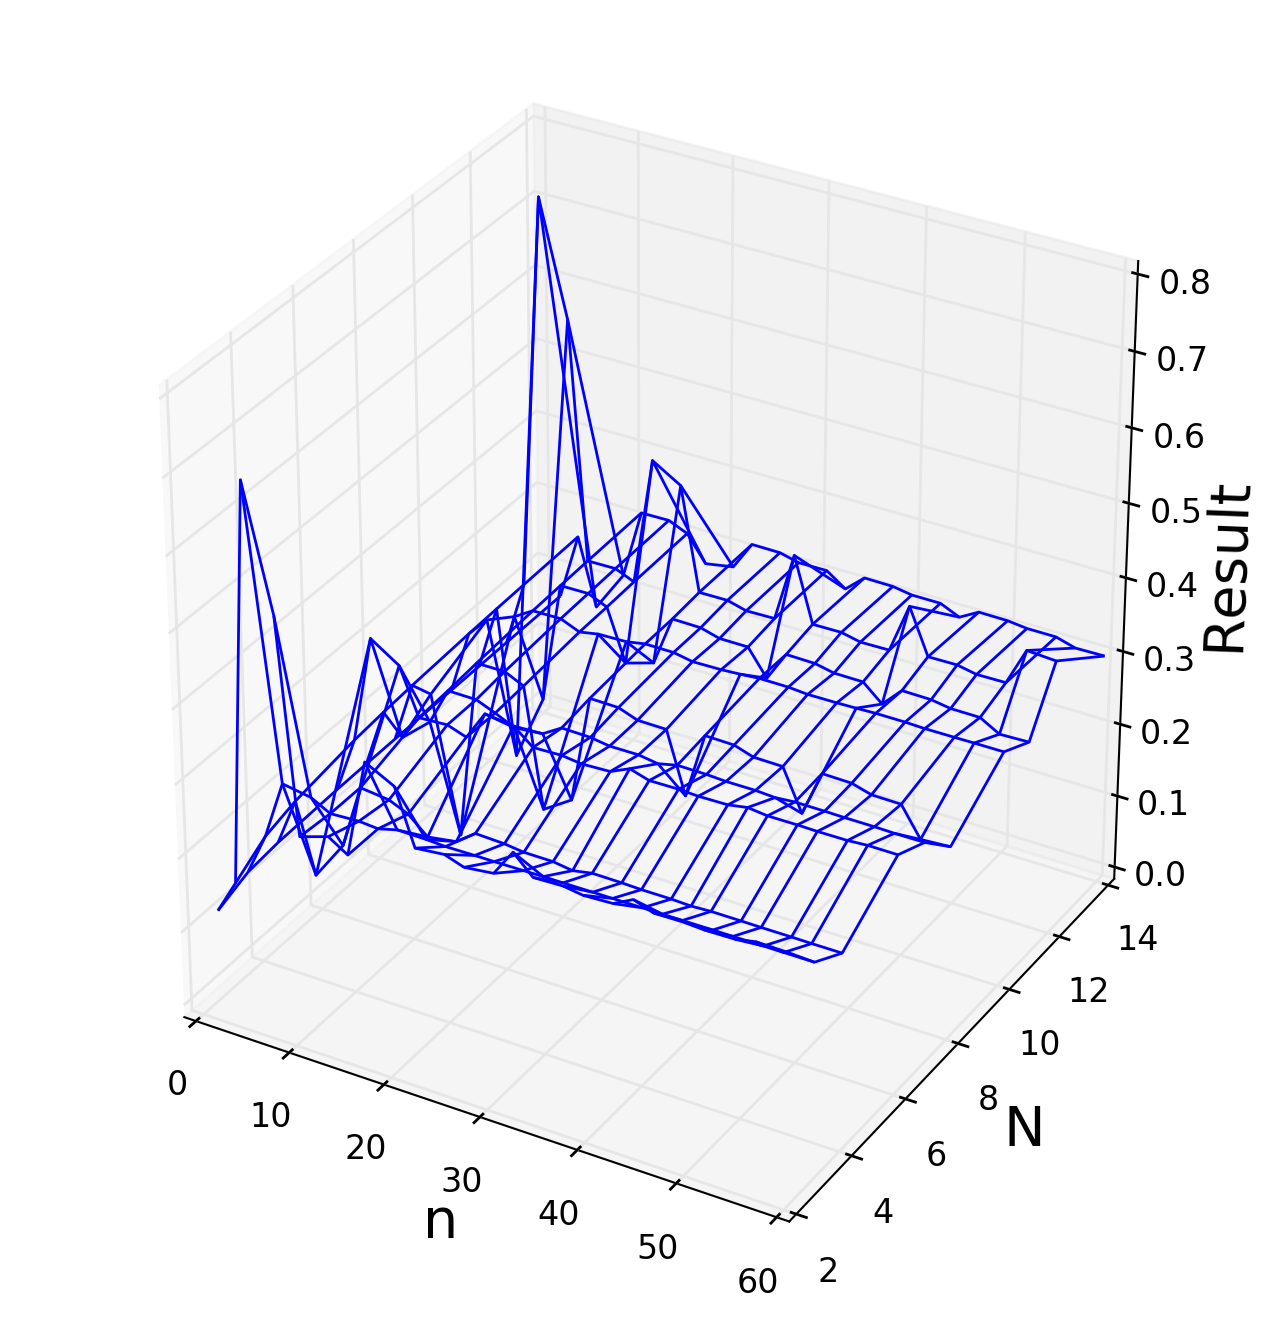

In [20]:
fig = pyplot.figure(figsize=(8, 8), dpi=200, facecolor='w', edgecolor='w', frameon=false)   
pyplot.style.use('classic')
wf = pyplot.axes(projection ='3d') 
wf.plot_wireframe(y, x, a) 

wf.set_xlabel('n', fontsize=20)
wf.set_ylabel('N', fontsize=20)
wf.set_zlabel('Result', fontsize=20)

pyplot.show() 
fig.savefig('TwoBoundaryConvergenceYX.jpg')